In [1]:
#loading dataset
import torchvision.transforms as transforms
from torchvision import datasets
import torch
#transforming dataset:
#1. converting to Tensor
#2. Normalizing images
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5)]
)
trainset = datasets.MNIST(root = './data', train = True, download=True, transform = transform)
#setting batchsize number
batch = 256
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch, shuffle=True, num_workers=2)



In [2]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [3]:

images.shape, labels.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

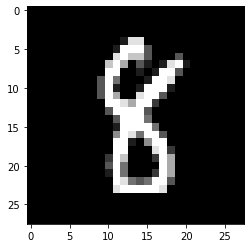

In [4]:
#plotting an image
from matplotlib import pyplot as plt
import numpy as np
plt.imshow(images[0].reshape((28, 28)), cmap='gray' )

In [5]:
#defining a plotting function for comparing images
def plot_it(images):
  for i, image in enumerate(images):
    if type(image) == torch.Tensor:
      images[i] = image.detach().numpy()
  image = np.hstack(images)
  plt.imshow(image, aspect='auto', cmap='gray')

In [6]:
#defining a test image for trying various transformations
sample_image = images[0].reshape((28,28))
type(sample_image)

torch.Tensor

In [7]:
#setting device for torch
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
print(device)

cuda:0


In [8]:
#convolutions
def corr2d(x, k):
  '''compute 2D cross-correlation'''
  h,w = k.shape
  #create an empty output of correct size
  Y = torch.zeros((x.shape[0]-h+1, x.shape[1]-w+1 ))
  #loop over the dimensions of the output image
  #calculate cross-corelation
  for i in range(Y.shape[0]):
    for j in range(Y.shape[1]):
      Y[i, j] = (x[i:i+h, j:j+w]*k).sum()
  return Y



In [9]:
#convolution in example
x = torch.tensor([[0, 1.0, 2.0], [3.0, 4.0, 5.0], [6.0, 7.0, 8.0]])
k = torch.tensor([[0, 1.0], [2.0, 3.0]])
corr2d(x,k)

tensor([[19., 25.],
        [37., 43.]])

In [10]:
#convolution using torch
from torch import nn
#defining kernel shape
conv2d = nn.Conv2d(1, 1, kernel_size = (2,2), bias=False)

In [11]:
#setting kernel values
conv2d.weight.data = torch.tensor([[0, 1.0], [2.0, 3.0]], dtype=torch.float32).reshape((1,1,2,2))

In [12]:
conv2d(x.reshape((1,1,3,3)))

tensor([[[[19., 25.],
          [37., 43.]]]], grad_fn=<ThnnConv2DBackward>)

In [13]:
#convolution on the test image
#define kernel shape
conv2d = conv2d = nn.Conv2d(1, 1, kernel_size = (1,2), bias=False)
#setting kernel values
conv2d.weight.data = torch.tensor([1.0, -1.0], dtype=torch.float32).reshape((1,1,1,2))

In [14]:
convoled_image = conv2d(sample_image.reshape(1,1,28,28))

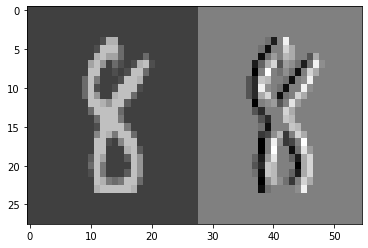

In [15]:
#plotting
plot_it([sample_image, convoled_image[0,0,:,:]])

In [16]:
sample_image.shape, convoled_image.shape

(torch.Size([28, 28]), torch.Size([1, 1, 28, 27]))

In [17]:
#defining kernel shape and padding
conv2d = nn.Conv2d(1, 1, kernel_size = (1,2), bias=False, padding=(0,10))

In [18]:
#setting kernel values
conv2d.weight.data = torch.tensor([1.0, -1.0], dtype=torch.float32).reshape((1,1,1,2))
#applying the kernel on the test image
convoled_image_pad = conv2d(sample_image.reshape(1,1,28,28))

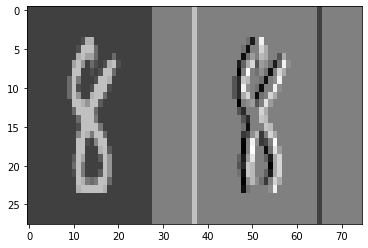

In [19]:
#plotting
plot_it([sample_image, convoled_image_pad[0,0,:,:]])

In [20]:
sample_image.shape, convoled_image_pad.shape

(torch.Size([28, 28]), torch.Size([1, 1, 28, 47]))

In [21]:
#define kernel shape, padding and stride
conv2d = nn.Conv2d(1, 1, kernel_size = (1,2), bias=False, padding=(0,0), stride=(1,2))


In [22]:
#setting kernel values
conv2d.weight.data = torch.tensor([1.0, -1.0], dtype=torch.float32).reshape((1,1,1,2))
#applying the kernel on the test image
convoled_image_stride = conv2d(sample_image.reshape(1,1,28,28))

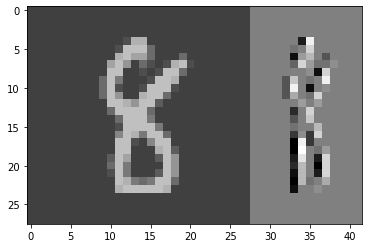

In [23]:
#plotting
plot_it([sample_image, convoled_image_stride[0,0,:,:]])

In [24]:
sample_image.shape, convoled_image_stride.shape

(torch.Size([28, 28]), torch.Size([1, 1, 28, 14]))

In [25]:
#maxpooling
pool2d = nn.MaxPool2d((2,2))
pooled_image = pool2d(sample_image.reshape(1,1,28,28))

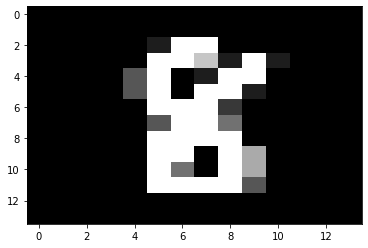

In [26]:
plot_it([pooled_image[0,0]])

In [27]:
pooled_image.shape

torch.Size([1, 1, 14, 14])

In [28]:
#learning a kernel
#creating two images x:input, y:transformed image
#using no_grad() so as not to remember the gradient
#using conv2d to form y
with torch.no_grad():
  X = images[0].reshape(1,1,28,28)
  conv2d = nn.Conv2d(1, 1, kernel_size = (1,2), bias=False)
  conv2d.weight.data = torch.tensor([1.0, -1.0], dtype=torch.float32).reshape((1,1,1,2))
  Y = conv2d(X)

In [29]:
#define kernel(no values set)
conv2d = nn.Conv2d(1, 1, kernel_size = (1,2), bias=False)
X = X.reshape(1,1,28,28)
Y = Y.reshape(1,1,28,27)
lr = 3*-1.282 #learning rate
#training loop
for i in range(100):
  #applying kernel input
  Y_hat = conv2d(X)
  #calculating the loss
  l = (Y-Y_hat)**2
  #setting gradients to zero
  conv2d.zero_grad()
  #backprop loss
  l.sum().backward()
  #update kernel
  conv2d.weight.data[:] -= lr*conv2d.weight.grad
  #print loss
  if (i+1)%10==0:
    print(f'loss{l.sum():.3f}')


lossinf
lossnan
lossnan
lossnan
lossnan
lossnan
lossnan
lossnan
lossnan
lossnan


In [30]:
conv2d.weight.data

tensor([[[[nan, nan]]]])

In [31]:
#LeNet
import torch.nn as nn
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    #define all kernels needed
    #conv2d_1
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
    #pool
    self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
    #conv2d_2
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
    #fully connected 1
    self.fc1 = nn.Linear(16*5*5, 120)
    #fully connected 2
    self.fc2 = nn.Linear(120,84)
    #fully connected 3
    self.fc3 = nn.Linear(84, 10)
  #defining how layers follows each other
  def forward(self, x):
    x = self.pool(torch.sigmoid(self.conv1(x)))
    x = self.pool(torch.sigmoid(self.conv2(x)))
    #flattening
    x = x.view(-1, 16*5*5)
    x = torch.sigmoid(self.fc1(x))
    x = torch.sigmoid(self.fc2(x))
    x = self.fc3(x)
    return x




In [32]:
net = Net()

In [33]:
#loss and optimizer
#setting loss and optimizer
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.5, momentum=0.9)

In [34]:
device

device(type='cuda', index=0)

In [35]:
#send net to device
#net.to(device)

In [36]:
#loop over the dataset multiple times
for epoch in range(10):
  #dataloader loop
  for i, (data, y) in enumerate(trainloader, 0):
    #getting inputs and sending to GPU
    #inputs, labels = data.to(device), y.to(device)
    inputs, labels = data, y
    #zero the parameter gradients
    optimizer.zero_grad()
    #forward+backward+optimize
    output = net(inputs)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
  print(f'loss at the final batch of each epoch {epoch} is:{loss.item():.3f}')


loss at the final batch of each epoch 0 is:2.300
loss at the final batch of each epoch 1 is:2.296
loss at the final batch of each epoch 2 is:1.718
loss at the final batch of each epoch 3 is:0.183
loss at the final batch of each epoch 4 is:0.320
loss at the final batch of each epoch 5 is:0.087
loss at the final batch of each epoch 6 is:0.057
loss at the final batch of each epoch 7 is:0.048
loss at the final batch of each epoch 8 is:0.015
loss at the final batch of each epoch 9 is:0.062


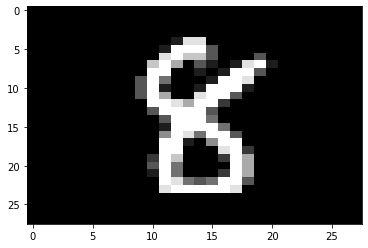

In [37]:
plot_it([sample_image])

In [38]:
#see prediction
torch.argmax(net(sample_image.reshape(1,1,28,28)))

tensor(8)

In [39]:
#VGG
#VGG requires large images
#resizing images using transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(0.5, 0.5),
     transforms.Resize(224)]
)
trainset = datasets.MNIST(root = './data', train = True, download=True, transform = transform)
#setting batchsize number
batch = 64
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch, shuffle=True, num_workers=2)

In [40]:
import torch
from torch import nn

In [41]:
#creating VGG blocks
#structure is:
#N(convolutions (3by3) + ReLU)
def vgg_block(num_convs, in_channels, out_channels):
  layers = []
  #loop to define number convs convolution kernels
  for _ in range(num_convs):
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
    layers.append(nn.ReLU())
    in_channels=out_channels
  #maxpooling
  layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
  return(nn.Sequential(*layers))

In [42]:
#making the network
#defining the architecture for blocks i.e (n_convs, out_channels)
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
def vgg(conv_arch):
  conv_blocks = []
  in_channels = 1
  #loop over architector to make vgg blocks
  for (num_convs, out_channels) in conv_arch:
    conv_blocks.append(vgg_block(num_convs, in_channels, out_channels))
    in_channels = out_channels
  #add final FC layers and return
  model = nn.Sequential(*conv_blocks, nn.Flatten(),
                        #FC layers
                        nn.Linear(out_channels*7*7, 4096),
                        nn.ReLU(),
                        nn.Dropout(0.5),
                        nn.Linear(4096, 4096),
                        nn.ReLU(),
                        nn.Dropout(0.5),
                        nn.Linear(4096, 10))
  return model



In [43]:
net = vgg(conv_arch)

In [44]:
#print network
x = torch.randn(size=(1,1,224,224))
for blk in net:
  x = blk(x)
  print(blk.__class__.__name__, 'output shape:\t', x.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])
